# Going Deeper with PyTorch Structure

In this post, we will be discussing how to implement more complex deep learning functionality using PyTorch. Some of the objectives of this posts are to make you understand.

1. The difference between PyTorch classes like `nn.Module`, `nn.Functional`, `nn.Parameter` and when to use which.
2. Custom training options such as different learning rates for different layers, different learning rate schedules
3. Custom Weight Initialisation

In [2]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import numpy as np
import pickle
import os
from PIL import Image
import random
import time
import torchvision

## nn.Module vs nn.Functional

In PyTorch, layers are often implemented as either one of `torch.nn.Module` objects or `torch.nn.Functional` functions. Which one to use?

`torch.nn.Module` is basically the cornerstone of PyTorch. The way it works is you first define an `nn.Module` object,  and then invoke it's `forward` method to run it. This is a `Object Oriented` way of doing things.

On the other hand, `nn.functional` provides some layers / activations in form of functions that can be directly called on the input rather than defining the an object. For example, in order to rescale an image tensor, you call `torch.nn.functional.interpolate` on an image tensor.

So how do we choose which to use? 

## Understanding Stateful-ness

Normally, any layer can be seen as a function. For example, a convolutional operation is just a bunch of multiplication and addition operations. So, it makes sense for us to just implement it as a function. However, the layer holds weights which need to be stored and updated while we are training. Therefore, from a programmatic angle, a layer is more than function. It also needs to hold data, which changes as we train our network.

Data held by the convolutional layer **changes**. which means that the layer has a state which changes as we train. Either we can implement a function that does the convolutional operation, and define a data structure to hold the weights separately from the function itself, and then, make this external data structure an input to the function. Or

> We can just define a class to hold the data structure, and make convolutional operation as an member function. This would really ease up our job, as we do not have to worry about stateful variables existing outside of the function. In these cases, we would prefer to use the `nn.Module` objects where we have weights or other states which might define the behaviour of the layer. For example, a dropout / Batch Norm layer behaves differently during training and inference.

> On the other hand, where no state or weights are required, one could use the `nn.functional`. Examples being, resizing (`nn.functional.interpolate`),  average pooling (`nn.functional.AvgPool2d`).

Despite the above reasoning, most of the `nn.Module` classes have their `nn.functional` counterparts.

## nn.Parameter

An important class in PyTorch is the `nn.Parameter` class. Consider the following case.

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 5)
        
    def forward(self, x):
        return self.linear(x)

simple_net = SimpleNet()
print(list(simple_net.parameters()))

[Parameter containing:
tensor([[ 0.0252,  0.2836, -0.3039,  0.0171, -0.1406, -0.0774, -0.3154, -0.2542,
         -0.2210, -0.0882],
        [-0.2884,  0.2595,  0.1202, -0.2203,  0.2965, -0.1442, -0.2895, -0.3071,
          0.2696,  0.2915],
        [-0.2565, -0.2405,  0.1172, -0.2581, -0.0788, -0.2189,  0.0937, -0.1916,
          0.2612, -0.0218],
        [ 0.1434, -0.0104,  0.2019,  0.0474, -0.2460, -0.2612,  0.2012, -0.2539,
         -0.0416,  0.1972],
        [-0.1513, -0.1396,  0.0666,  0.2680,  0.1164,  0.1208, -0.0457, -0.2880,
         -0.0297,  0.2010]], requires_grad=True), Parameter containing:
tensor([ 0.0398,  0.1742,  0.1323, -0.1462,  0.1570], requires_grad=True)]


When we define a net (subclass of `nn.Module`) and leverage a PyTorch built-in layer module such as `nn.Conv2d`, we do not need to add the parameters of `nn.Conv2d` to parameters of net. It happened implicitly by virtue of setting `nn.Conv2d` object as a member of the net object.

This is internally facilitated by the `nn.Parameter` class, which subclasses the Tensor class. When we invoke `parameters()` function of a `nn.Module` object, it returns all its members which are `nn.Parameter` objects.

> All the training weights of `nn.Module` classes are implemented as `nn.Parameter` objects. Whenever, a `nn.Module` object (nn.Conv2d in our case) is assigned as a member of another `nn.Module`, the "parameters" of the assignee `nn.Module` object (i.e. the weights of `nn.Conv2d`) are also added the "parameters" of the `nn.Module` object which is being assigned to (parameters of net object). This is called `registering` "parameters" of a `nn.Module`

If you try to assign a tensor to the `nn.Module` object, it won't show up in the `parameters()` unless you define it as `nn.Parameter` object. This has been done to facilitate scenarios where you might need to cache a non-differentiable tensor, example in case, caching previous output in case of RNNs.

In [13]:
class net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
        self.tens = torch.ones(3,4) # This won't show up in a parameter list 
    
    def forward(self, x):
        return self.linear(x)

myNet = net1()
print(list(myNet.named_parameters()))

[('linear.weight', Parameter containing:
tensor([[ 0.0852,  0.2504, -0.1351, -0.0247,  0.0808,  0.3004, -0.2279, -0.0225,
          0.0478, -0.2327],
        [-0.3057, -0.2100,  0.1080, -0.1771, -0.1293, -0.1323, -0.1504, -0.1108,
         -0.1813, -0.3118],
        [ 0.1201, -0.1547, -0.0886, -0.3014,  0.2451, -0.0148, -0.2312,  0.2971,
          0.2368,  0.2860],
        [-0.2337,  0.0546, -0.1255,  0.2235, -0.0570,  0.2856,  0.0514,  0.0917,
          0.0964, -0.2239],
        [ 0.1191, -0.0888, -0.1580, -0.0884,  0.2290,  0.3156, -0.1580, -0.2336,
         -0.2232, -0.1244]], requires_grad=True)), ('linear.bias', Parameter containing:
tensor([ 0.0799,  0.0927, -0.1188, -0.0356,  0.0436], requires_grad=True))]


In [12]:
class net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5) 
        self.tens = nn.Parameter(torch.ones(3,4)) # This will show up in a parameter list 
    
    def forward(self, x):
        return self.linear(x)

myNet = net2()
print(list(myNet.named_parameters()))

[('tens', Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)), ('linear.weight', Parameter containing:
tensor([[ 0.3014,  0.1304, -0.0963,  0.2978,  0.2582, -0.2182,  0.2930,  0.1501,
         -0.1452,  0.2025],
        [-0.1742, -0.2584, -0.2888, -0.2022, -0.2849, -0.3087, -0.0121,  0.0928,
         -0.3006, -0.0834],
        [ 0.1842, -0.1537, -0.2558,  0.0871,  0.1161, -0.2095, -0.0910,  0.0154,
          0.3136, -0.1224],
        [ 0.2583,  0.1148,  0.2160, -0.1627, -0.1739,  0.2727,  0.0292, -0.1146,
          0.1640, -0.2952],
        [ 0.2566,  0.1701, -0.1846,  0.0094, -0.0991,  0.2755, -0.0749,  0.2738,
          0.0184,  0.2690]], requires_grad=True)), ('linear.bias', Parameter containing:
tensor([-0.2042,  0.2643, -0.2221, -0.0116, -0.2130], requires_grad=True))]


In [14]:
class net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5) 
        self.sub_net  = net2() # Parameters of net2 will show up in list of parameters of net3
    
    def forward(self, x):
        return self.linear(x)


myNet = net3()
print(list(myNet.named_parameters()))

[('linear.weight', Parameter containing:
tensor([[ 0.0612,  0.2361,  0.2638,  0.1153,  0.1726,  0.3016,  0.1860, -0.1373,
         -0.1924,  0.2928],
        [ 0.0947, -0.2412, -0.2797, -0.2670, -0.0784,  0.0892,  0.2124, -0.3056,
          0.1527, -0.1618],
        [-0.1180,  0.2467,  0.0416,  0.1575,  0.1210,  0.2373, -0.3120, -0.1024,
         -0.0893, -0.0759],
        [-0.2030,  0.1476,  0.0172, -0.1674,  0.0695, -0.2864,  0.0680, -0.0952,
          0.2752,  0.1475],
        [ 0.1653,  0.1993,  0.1463,  0.1912,  0.2653, -0.2367, -0.2035, -0.2700,
          0.2169,  0.0812]], requires_grad=True)), ('linear.bias', Parameter containing:
tensor([ 0.2582, -0.0540, -0.3131, -0.1285,  0.1488], requires_grad=True)), ('sub_net.tens', Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)), ('sub_net.linear.weight', Parameter containing:
tensor([[-0.2313,  0.1468, -0.0252, -0.3159,  0.3098,  0.1960,  0.0514,  0.0687,
        

## nn.ModuleList and nn.ParameterList()

When we made a `nn.ModuleList` object a member of our defined net class, all members, including their parameters, inside the `nn.ModuleList` list will be registered as a member of the net object

In [18]:
layer_list = [nn.Conv2d(2,2,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(layer_list)
  
    def forward(x):
        for layer in self.layers:
            x = layer(x)

net = myNet()

print(list(net.named_parameters()))  # Parameters of modules in layer_list show up.

[('layers.0.weight', Parameter containing:
tensor([[[[ 0.1992,  0.1196, -0.0622],
          [-0.0323,  0.0642,  0.0576],
          [ 0.0334, -0.1276, -0.0024]],

         [[-0.2122, -0.0962, -0.1099],
          [-0.1497, -0.1558, -0.1632],
          [-0.2349,  0.2146, -0.0615]]],


        [[[ 0.0285, -0.0818,  0.0092],
          [-0.2058, -0.2257,  0.1678],
          [-0.0912, -0.1038, -0.1138]],

         [[ 0.0257, -0.2277,  0.0759],
          [ 0.0907,  0.1693, -0.0356],
          [-0.1944, -0.1999,  0.0489]]]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.1099, 0.0754], requires_grad=True)), ('layers.1.weight', Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)), ('layers.1.bias', Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)), ('layers.2.weight', Parameter containing:
tensor([[ 0.3045, -0.0475,  0.0247,  0.3987,  0.2710],
        [ 0.3516, -0.2260, -0.3656,  0.0198, -0.0681]], requires_grad=True)), ('layers.2

As you see, assigning a Python List doesn't register the parameters of Modules inside the list.

In [19]:
layer_list = [nn.Conv2d(5,5,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = layer_list
  
    def forward(x):
        for layer in self.layers:
            x = layer(x)

net = myNet()

print(list(net.parameters()))  # Parameters of modules in the layer_list don't show up.

[]


## Weight Initialization

Weight initialization can influence the results of training. We may require different weight initialization schemes for different sort of layers. This can be accomplished by the `modules()` function, which is a member function of the `nn.Module` class that returns an iterator containing all the `nn.Module` member objects of that `nn.Module` class. 

There are a plethora of inplace initialization functions to be found in the `torch.nn.init` module

SimpleNet2(
  (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


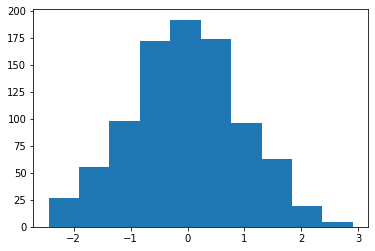

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

class SimpleNet2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(10, 10, 3)
        self.bn = nn.BatchNorm2d(10)
        
    def weights_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean=0, std=1)
                nn.init.constant_(module.bias, 0)
                
simple_net2 = SimpleNet2()
simple_net2.weights_init()
print(simple_net2)

for module in simple_net2.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().numpy()
        print(module.bias)
        plt.hist(weights)
        plt.show()

## modules() vs children()

A very similar function to modules is children. The difference is a slight but an important one. As we know, a nn.Module object can contain other nn.Module objects as it's data members.

* `children()` will only return a list of the `nn.Module` objects which are members of the object on which children is being called.

* `modules()` goes **recursively** inside each `nn.Module` object, creating a list of each `nn.Module` object that comes along the way until there are no `nn.module` objects left. Note that `modules()` also returns the `nn.Module` object on which the `modules()` has been called as a part of the list.

> Therefore, when we initialize the weights, we might want to use `modules()` function since we can't go inside the `nn.Sequential` object and initialize the weight for its members.

Note, that the above statement remains true for subclasses inherited from `nn.Module` class.

In [13]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN =  nn.Sequential(nn.Conv2d(10,10,3), nn.BatchNorm2d(10))
        self.linear =  nn.Linear(10,2)
    
    def forward(self, x):
        pass

net = myNet()

print("Printing children\n------------------------------")
print(list(net.children()))
print("\n\nPrinting Modules\n------------------------------")
# print(list(net.modules()))
for idx, m in enumerate(net.modules()):
    print("{0} :{1}".format(idx, m))

Printing children
------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


Printing Modules
------------------------------
0 :myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
)
1 :Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
2 :Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
3 :BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
4 :Linear(in_features=10, out_features=2, bias=True)


## Printing Information About the Network
We may need to print information about the network, whether be it for the user or for debugging purposes. PyTorch provides a neat way to print a lot of information about out network using it's `named_*` functions. There are 4 such functions.

1. `named_parameters`, returns an iterator which gives a tuple containing **name** of the parameters (if a convolutional layer is assigned as `self.conv1`, then it's parameters would be `conv1.weight` and `conv1.bias`) and the value returned by the **__repr__** function of the `nn.Parameter`.
2. `named_modules`. Same as above, but iterator returns modules like `modules()` function does.

3. `named_children` Same as above, but iterator return modules like `children()` returns.

4. `named_buffers` Return buffer tensors such as running mean average of a Batch Norm layer.


In [16]:
for x in net.named_modules():
    print(x[0], "," ,x[1], "\n-------------------------------")

 , myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
) 
-------------------------------
convBN , Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
convBN.0 , Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
convBN.1 , BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------
linear , Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


## Different Learning Rates For Different Layers

In this section, we will learn how to use different learning rates for our different layers. In general, we will cover how to have different hyperparameters for different groups of parameters, whether it be different learning rate for different layers, or different learning rate for biases and weights.

n our previous post, where we implemented a CIFAR classifier, we passed all the parameters of network as a whole to the optimiser object.

In [17]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)
    
    def forward(self, x):
        return self.fc2(self.fc1(x))

net = myNet()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)

However, the `torch.optim` class allows us to provide different sets of parameters with different learning rates in form of a dictionary.

In [29]:

optimizer = torch.optim.SGD([{"params": net.fc1.parameters(), "lr" : 0.001, "momentum" : 0.99},
                             {"params": net.fc2.parameters(), "lr" : 0.01}])

optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.99
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In the above scenario, the parameters of `fc1` use a learning rate of 0.001 and momentum of 0.99. If a hyperparameter is not specified for a group of parameters (like `fc2`), they use the default value of that hyperparameter. You could create parameter lists on basis of different layers, or layers' weights or biases, using the `named_parameters()` function we covered above.

## Learning Rate Scheduling

Learning rate is a major hyperparameter that we want to tune. PyTorch provides support for scheduling learning rates with it's `torch.optim.lr_scheduler` module which has a variety of learning rate schedules. The following example demonstrates one such example:

In [31]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [10,20], gamma = 0.1)

The `MultiStepLR` scheduler multiplies the learning rate by `gamma` each time when we reach `epochs` contained in the `milestones` list. In our example, the learning rate is multiplied by 0.1 at the 10nth and the 20nth epoch. You will also have to write the line `scheduler.step` in the loop in your code that goes over the epochs so that the learning rate is updated.

> Generally, training loop is made of two nested loops, where one loop goes over the epochs, and the nested one goes over the batches in that epoch. Make sure you call `scheduler.step` at start of the epoch loop so your learning rate is updated. Be careful not to write it in the batch loop, otherwise your learning rate may be updated at the 10th batch rather than 10nth epoch.

> Also remember that `scheduler.step` is no replacement for `optim.step` and we will have to call `optim.step` everytime we backprop backwards. (This would be in the "batch" loop).